In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
sns.set(style="whitegrid")


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


In [ ]:
df = pd.read_csv("Dataset/games_eda.csv")
df

,Name,Peak CCU,Required age,Price,DLC count,About the game,Windows,Mac,Linux,Achievements,...,Log Peak CCU,Log Price,Log Achievements,Log DLC count,Log Median playtime forever,Log Num Languages,Log Developers freq,Log Publishers freq,Log Recommendations,About length
0,Wartune Reborn,68,0,0.00,0,Feel tired of auto-fight? Feel tired of boring...,1,0,0,0,...,4.234107,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147,0.000000,293
1,TD Worlds,3,0,10.99,1,"TD Worlds is a dynamic, highly strategical gam...",1,0,0,62,...,1.386294,2.484073,4.143135,0.693147,0.000000,1.386294,0.693147,0.693147,0.000000,129
2,MazM: Jekyll and Hyde,1,0,14.99,0,'MazM: Jekyll and Hyde' is a darkly entertaini...,1,0,0,25,...,0.693147,2.771964,3.258097,0.000000,0.000000,2.397895,1.098612,2.639057,0.000000,168
3,WARSAW,5,0,23.99,0,Use everything at your disposal to help a team...,1,0,0,34,...,1.791759,3.218476,3.555348,0.000000,4.543295,1.791759,1.098612,0.693147,6.059123,393
4,Diary of Lucie,3,0,12.99,0,Diary of Lucie is action-roguelite game made w...,1,0,0,0,...,1.386294,2.638343,0.000000,0.000000,0.000000,1.098612,0.693147,0.693147,0.000000,284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,When The Devil Takes Hold,3,0,3.99,0,When The Devil Takes Hold is a singleplayer ps...,1,0,0,8,...,1.386294,1.607436,2.197225,0.000000,0.000000,1.386294,0.693147,0.693147,0.000000,322
22101,RIOO,2,0,0.99,0,Fight against incoming monsters with other bra...,1,0,0,6,...,1.098612,0.688135,1.945910,0.000000,0.000000,1.386294,0.693147,0.693147,0.000000,82
22102,The Mightiest Sword is Mine!,2,0,2.99,0,Embark on a Journey of Limitless Growth! What ...,1,0,0,50,...,1.098612,1.383791,3.931826,0.000000,0.000000,1.386294,0.693147,0.693147,0.000000,213
22103,HAREM！RANCH LIFE,76,0,16.19,0,This is a relaxing farm RPG game where you can...,1,0,0,0,...,4.343805,2.844328,0.000000,0.000000,0.000000,1.609438,0.693147,1.386294,4.644391,96


In [18]:
columns = df.columns.tolist()
print(columns)

['Name', 'Peak CCU', 'Required age', 'Price', 'DLC count', 'About the game', 'Windows', 'Mac', 'Linux', 'Achievements', 'Recommendations', 'Average playtime two weeks', 'Median playtime forever', 'Developers', 'Publishers', 'Game Age (Days)', 'is_indie', 'Owner range', 'Total Reviews', 'Review Ratio', 'Num Languages', 'Is English Supported', 'Tags_Singleplayer', 'Tags_Adventure', 'Tags_Action', 'Tags_Casual', 'Tags_2D', 'Tags_Strategy', 'Tags_Simulation', 'Tags_RPG', 'Tags_Atmospheric', 'Tags_Story Rich', 'Tags_Multiplayer', 'Tags_Puzzle', 'Tags_3D', 'Tags_Fantasy', 'Tags_Exploration', 'Tags_Cute', 'Tags_First-Person', 'Tags_Early Access', 'Tags_Colorful', 'Tags_Pixel Graphics', 'Tags_Anime', 'Tags_Funny', 'Tags_Female Protagonist', 'Tags_Horror', 'Tags_Open World', 'Tags_Sci-fi', 'Tags_Great Soundtrack', 'Tags_Shooter', 'Tags_Co-op', 'Tags_Family Friendly', 'Tags_Relaxing', 'Tags_Arcade', 'Tags_Retro', 'Tags_Difficult', 'Tags_Action-Adventure', 'Tags_Third Person', 'Tags_Sandbox', 'Ta

In [22]:
numerical_predictors = ['Review Ratio',
 'Log Total Reviews',
 'Log Peak CCU',
 'Log Price',
 'Game Age (Days)',
 'Log Achievements',
 'Log DLC count',
 'Log Median playtime forever',
 'Log Num Languages',
 'Log Developers freq',
 'Log Publishers freq']

categorical_predictors = [
    'is_indie', 'Is English Supported',
    'Windows', 'Mac', 'Linux',
    *[tag for tag in columns if tag.startswith('Tags_')],
    *[genre for genre in columns if genre.startswith('Genres_')],
    *[category for category in columns if category.startswith('Categories_')],
]


target_var = 'Owner range'

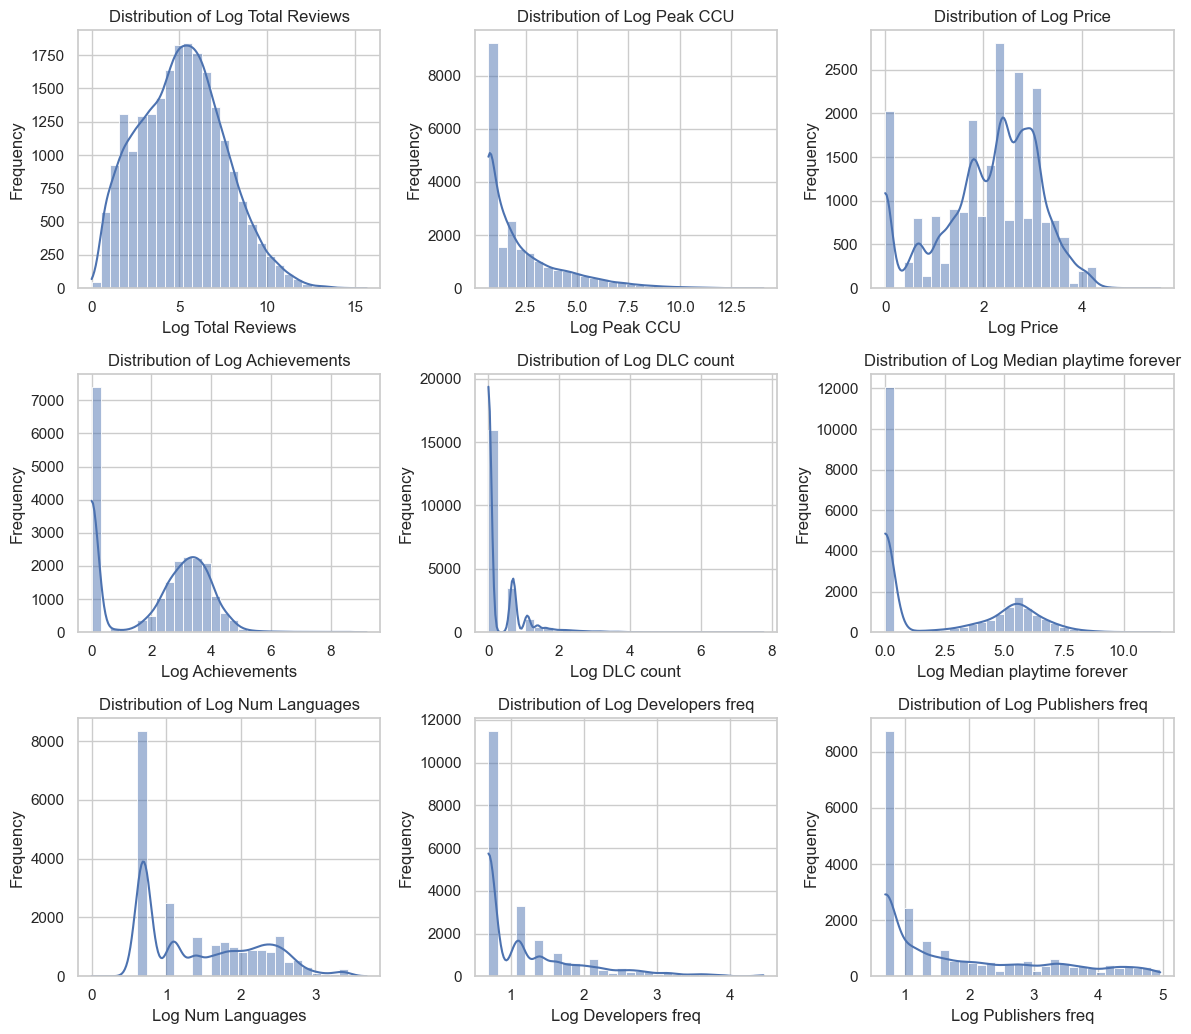

,Total Reviews,Peak CCU,Price,Achievements,DLC count,Median playtime forever,Num Languages,Developers freq,Publishers freq
count,2.210500e+04,2.210500e+04,22105.000000,22105.000000,22105.000000,22105.000000,22105.000000,22105.000000,22105.000000
mean,4.091226e+03,7.057119e+02,11.837520,30.921873,1.396109,259.348880,5.037458,4.063560,15.084053
std,5.484831e+04,1.611792e+04,11.695174,182.473190,25.029620,1584.037717,5.287239,7.894377,27.464406
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.600000e+01,1.000000e+00,3.990000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.680000e+02,4.000000e+00,9.990000,14.000000,0.000000,0.000000,3.000000,1.000000,2.000000
75%,8.820000e+02,2.200000e+01,16.190000,33.000000,1.000000,212.000000,8.000000,4.000000,14.000000
max,6.531097e+06,1.284268e+06,269.990000,9821.000000,2366.000000,102435.000000,39.000000,85.000000,142.000000


In [23]:
skewed_cols = [
    'Total Reviews', 'Peak CCU', 'Price', 'Achievements', 'DLC count', 'Median playtime forever', 'Num Languages', 'Developers freq', 'Publishers freq'
]

for col in skewed_cols:
    df[f"Log {col}"] = np.log1p(df[col]) # Applying log transformation to skewed columns

plt.figure(figsize=(3 * 4, 3 * 3.5))

for i, col in enumerate(skewed_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[f"Log {col}"], kde=True, bins=30)
    plt.title(f'Distribution of Log {col}')
    plt.xlabel(f'Log {col}')
    plt.ylabel('Frequency')
plt.tight_layout()

plt.show()
display(df[skewed_cols].describe())

In [25]:
#[skewed_cols]
#df.drop(columns=[target_var,'Name'])
X = pd.DataFrame(df[categorical_predictors + numerical_predictors]) # Predicter 
y = pd.DataFrame(df[target_var]) # Response
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [26]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print("Original class distribution:")
print(df.groupby("Owner range").aggregate({"Owner range":"count"}))



Original class distribution:
             Owner range
Owner range             
1                  10825
2                   3297
3                   2359
4                   1947
5                   1844
6                    855
7                    501
8                    324
9                     90
10                    36
11                    21
12                     5
13                     1


In [27]:
import pandas as pd

# Combine rare classes
def merge_rare_classes(y):
    y = y.copy()
    y[y >= 11] = 11  # Merging 11, 12, 13 into one class
    return y

y_merged = merge_rare_classes(y)

from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=2, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_merged)

X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, test_size = 0.25)

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [29]:
# Predict values 
# y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))

print(classification_report(y_test, y_test_pred))

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5871033900349861
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5981545142030035
              precision    recall  f1-score   support

           1       0.81      0.95      0.87      2746
           2       0.32      0.14      0.19       789
           3       0.29      0.36      0.32       639
           4       0.31      0.28      0.29       468
           5       0.31      0.52      0.39       444
           6       0.11      0.01      0.02       210
           7       0.00      0.00      0.00       119
           8       0.00      0.00      0.00        77
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.60      5527
   macro avg     

c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [30]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_resampled_train, y_resampled_train)

c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [31]:
# Predict values 
# y_resampled_train_pred = lr.predict(X_resampled_train)
# y_resampled_test_pred = lr.predict(X_resampled_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_resampled_train, y_resampled_train))
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_resampled_test, y_resampled_test))

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.529852417530737
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5299136685814102


c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.33      0.12      0.17      2746
           2       0.22      0.16      0.19       789
           3       0.28      0.21      0.24       639
           4       0.21      0.20      0.20       468
           5       0.27      0.11      0.15       444
           6       0.31      0.19      0.24       210
           7       0.26      0.16      0.20       119
           8       0.26      0.06      0.10        77
           9       0.20      0.10      0.13        20
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.14      5527
   macro avg       0.17      0.09      0.12      5527
weighted avg       0.29      0.14      0.19      5527



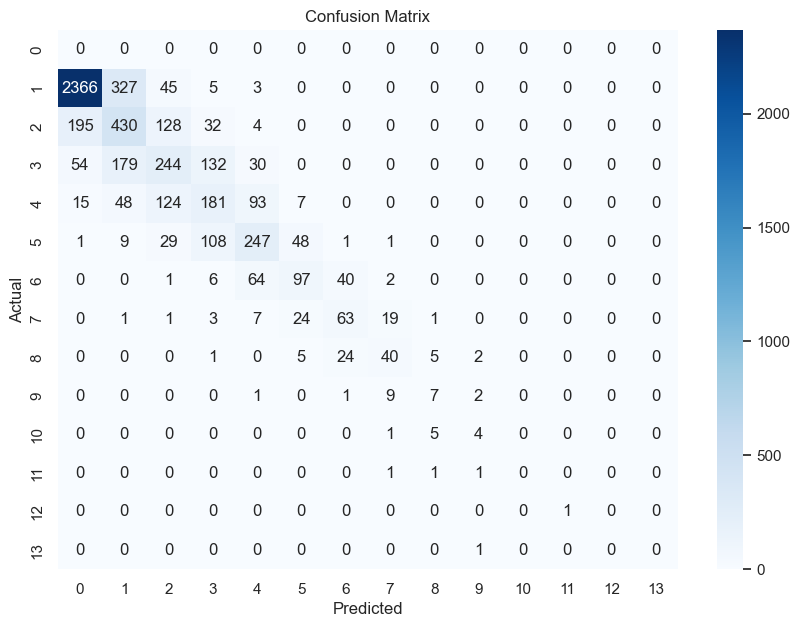

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
y_train_xg = y_train - 1
# Step 2: Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_xg)

# Step 3: Train XGBoost model
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=13,  # Adjust if you merged rare classes
    random_state=42,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train_xg, sample_weight=sample_weights)

# Step 4: Evaluate the model
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

# Step 5: Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lgbm = lgb.LGBMClassifier(class_weight='balanced', random_state=42,is_unbalance=True)
lgbm.fit(X_train, y_train) 

c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2812
[LightGBM] [Info] Number of data points in the train set: 16578, number of used features: 475
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start tr

LGBMClassifier(class_weight='balanced', is_unbalance=True, random_state=42)

In [34]:
# Predict values 
# y_train_pred = lr.predict(X_train)
y_test_pred = lgbm.predict(X_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lgbm.score(X_train, y_train))
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lgbm.score(X_test, y_test))

print(classification_report(y_test, y_test_pred))

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.929062613101701
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6726976660032568
              precision    recall  f1-score   support

           1       0.90      0.86      0.88      2746
           2       0.44      0.56      0.49       789
           3       0.44      0.40      0.42       639
           4       0.39      0.37      0.38       468
           5       0.56      0.56      0.56       444
           6       0.53      0.51      0.52       210
           7       0.52      0.55      0.54       119
           8       0.60      0.56      0.58        77
           9       0.50      0.35      0.41        20
          10       0.67      0.40      0.50        10
          11       0.25      0.33      0.29         3
          12       0.33      1.00      0.50         1
          13       0.00      0.00      0.00         1

    accuracy                           0.67      5527
   macro avg      

c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyeal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [35]:
for x in df[categorical_predictors + numerical_predictors].columns:
    print(x)

is_indie
Is English Supported
Windows
Mac
Linux
Tags_Singleplayer
Tags_Adventure
Tags_Action
Tags_Casual
Tags_2D
Tags_Strategy
Tags_Simulation
Tags_RPG
Tags_Atmospheric
Tags_Story Rich
Tags_Multiplayer
Tags_Puzzle
Tags_3D
Tags_Fantasy
Tags_Exploration
Tags_Cute
Tags_First-Person
Tags_Early Access
Tags_Colorful
Tags_Pixel Graphics
Tags_Anime
Tags_Funny
Tags_Female Protagonist
Tags_Horror
Tags_Open World
Tags_Sci-fi
Tags_Great Soundtrack
Tags_Shooter
Tags_Co-op
Tags_Family Friendly
Tags_Relaxing
Tags_Arcade
Tags_Retro
Tags_Difficult
Tags_Action-Adventure
Tags_Third Person
Tags_Sandbox
Tags_Survival
Tags_Controller
Tags_Comedy
Tags_Platformer
Tags_Realistic
Tags_Visual Novel
Tags_Psychological Horror
Tags_Choices Matter
Tags_Mystery
Tags_FPS
Tags_Top-Down
Tags_Management
Tags_Building
Tags_Combat
Tags_Point & Click
Tags_Stylized
Tags_Dark
Tags_Multiple Endings
Tags_Free to Play
Tags_PvP
Tags_Rogue-like
Tags_Character Customization
Tags_Gore
Tags_Sexual Content
Tags_Violent
Tags_Tactical
T